In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files

In [ ]:
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

In [2]:
import pandas as pd
import numpy as np
from keras.layers import GRU, Activation, Dropout, Dense, Input
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential
from keras.utils import np_utils
import string
import re
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.under_sampling import RandomUnderSampler
from datetime import datetime
import pickle

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# tf.debugging.set_log_device_placement(True)

In [ ]:
data = pd.read_json('/content/drive/My Drive/Master Thesis/Data/train_test_2005_2018_cleaned.json')

In [ ]:
uos = RandomUnderSampler(random_state=45)
data_x, data_y = uos.fit_resample(np.array(data['cleaned_text']).reshape(-1,1),np.array(data['stars']).reshape(-1,1))
data_us = pd.DataFrame(list(zip([x[0] for x in data_x], data_y)), columns = ['cleaned_text', 'stars'])

In [ ]:
# saving
with open('/content/drive/My Drive/Master Thesis/Model/keras_gru_tokenizer_2005_2018.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
data_us.stars.value_counts()
#data_us.head(1)

1    204237
2    204237
3    204237
4    204237
5    204237
Name: stars, dtype: int64

In [ ]:
data_us['stars_reduce'] = data_us['stars']-1

In [ ]:
dummy_y = np_utils.to_categorical(data_us.stars_reduce)
dummy_y.shape

(1021185, 5)

In [ ]:
X_train, X_test,Y_train, Y_test = train_test_split(data_us.cleaned_text, dummy_y, test_size=0.2, random_state = 45)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

#words_to_index is the dictionary mapping words to their respective index.
words_to_index = tokenizer.word_index

In [ ]:
maxLen = 300
vocab_len = len(words_to_index)+1
embedding_dim = 64

In [ ]:
def gru_model(input_shape):

  X_indices = Input(input_shape)

  embeddings = Embedding(input_dim=vocab_len, output_dim=embedding_dim, input_length=maxLen)(X_indices)

  X = GRU(128, return_sequences=True)(embeddings)

  X = Dropout(0.5)(X)

  X = GRU(128, return_sequences=True)(X)

  X = Dropout(0.5)(X)

  X = GRU(128, return_sequences=True)(X)

  X = Dropout(0.5)(X)

  X = GRU(128)(X)

  X = Dropout(0.5)(X)

  X = Dense(5, activation='softmax')(X)

  model = Model(inputs=X_indices, outputs=X)

  return model

In [ ]:
model = gru_model((maxLen,))
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 300, 64)           11257280  
                                                                 
 gru_8 (GRU)                 (None, 300, 128)          74496     
                                                                 
 dropout_6 (Dropout)         (None, 300, 128)          0         
                                                                 
 gru_9 (GRU)                 (None, 300, 128)          99072     
                                                                 
 dropout_7 (Dropout)         (None, 300, 128)          0         
                                                                 
 gru_10 (GRU)                (None, 300, 128)          9907

In [ ]:
X_train_indices = tokenizer.texts_to_sequences(X_train)

X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen, padding='post')

print(X_train_indices.shape)

X_test_indices = tokenizer.texts_to_sequences(X_test)

X_test_indices = pad_sequences(X_test_indices, maxlen=maxLen, padding='post')

(816948, 300)


In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate = 1e-4)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
callback = EarlyStopping(monitor='val_loss', patience=2)
epochs=20

In [ ]:
start_time = datetime.now()
history = model.fit(X_train_indices, Y_train, validation_data=(X_test_indices, np.asarray(Y_test)), batch_size=64, epochs=epochs, callbacks=[callback])
end_time = datetime.now()
print('--- Duration ---{}'.format(end_time - start_time))

Epoch 1/20
12765/12765 [==============================] - 950s 74ms/step - loss: 1.6009 - accuracy: 0.2210 - val_loss: 1.4804 - val_accuracy: 0.3155
Epoch 2/20
12765/12765 [==============================] - 942s 74ms/step - loss: 1.3202 - accuracy: 0.3890 - val_loss: 0.9327 - val_accuracy: 0.5843
Epoch 3/20
12765/12765 [==============================] - 946s 74ms/step - loss: 0.8925 - accuracy: 0.6057 - val_loss: 0.8584 - val_accuracy: 0.6173
Epoch 4/20
12765/12765 [==============================] - 933s 73ms/step - loss: 0.8361 - accuracy: 0.6316 - val_loss: 0.8336 - val_accuracy: 0.6288
Epoch 5/20
12765/12765 [==============================] - 936s 73ms/step - loss: 0.8074 - accuracy: 0.6471 - val_loss: 0.8325 - val_accuracy: 0.6312
Epoch 6/20
12765/12765 [==============================] - 935s 73ms/step - loss: 0.7851 - accuracy: 0.6585 - val_loss: 0.8205 - val_accuracy: 0.6372
Epoch 7/20
12765/12765 [==============================] - 927s 73ms/step - loss: 0.7662 - accuracy: 0.6682

Text(0.5, 1.0, 'Accuracy')

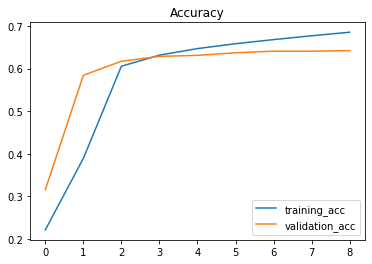

In [ ]:
#plot accuracy
# plt.figure(figsize=(15, 7))
plt.plot(range(9), history.history['accuracy'])
plt.plot(range(9), history.history['val_accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

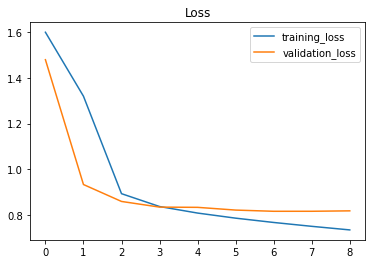

In [ ]:
#plot loss
# plt.figure(figsize=(15, 7))
plt.plot(range(9), history.history['loss'])
plt.plot(range(9), history.history['val_loss'])
plt.legend(['training_loss', 'validation_loss'])
plt.title('Loss')

In [ ]:
model.evaluate(X_test_indices, Y_test)

6383/6383 [==============================] - 130s 20ms/step - loss: 0.8172 - accuracy: 0.6423


[0.8171566724777222, 0.6423321962356567]

In [ ]:
model.save('/content/drive/My Drive/Master Thesis/Model/keras_gru_2015_2018')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Master Thesis/Model/keras_gru_2015_2018/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Master Thesis/Model/keras_gru_2015_2018/assets


In [4]:
loaded_model = keras.models.load_model('/content/drive/My Drive/Master Thesis/Model/keras_gru_2015_2018')

In [ ]:
np.testing.assert_allclose(
    model.predict(X_test_indices), loaded_model.predict(X_test_indices)
)

In [5]:
data_test = pd.read_json('/content/drive/My Drive/Master Thesis/Data/restaurant_review_2019_cleaned_deep_prediction.json')

In [6]:
# loading tokenizer
with open('/content/drive/My Drive/Master Thesis/Model/keras_gru_tokenizer_2005_2018.pickle', 'rb') as handle:
    keras_tokenizer = pickle.load(handle)

In [7]:
maxLen = 300
test_indices = keras_tokenizer.texts_to_sequences(data_test.cleaned_text)

test_indices = pad_sequences(test_indices, maxlen=maxLen, padding='post')

print(test_indices.shape)

(524593, 300)


In [8]:
preds = loaded_model.predict(test_indices)

In [9]:
stars_pred = np.argmax(preds, axis=1)+1

In [10]:
confusion_matrix(data_test.stars, stars_pred)

array([[ 54123,  12130,   1451,    259,    441],
       [ 10625,  22602,   5903,    583,    240],
       [  2411,  13099,  27075,   6926,   1137],
       [   534,   1488,  15671,  56219,  27404],
       [  1075,    578,   3447,  49009, 210163]])

In [11]:
print(classification_report(data_test.stars, stars_pred))

              precision    recall  f1-score   support

           1       0.79      0.79      0.79     68404
           2       0.45      0.57      0.50     39953
           3       0.51      0.53      0.52     50648
           4       0.50      0.55      0.52    101316
           5       0.88      0.80      0.83    264272

    accuracy                           0.71    524593
   macro avg       0.62      0.65      0.63    524593
weighted avg       0.72      0.71      0.71    524593



In [12]:
data_test['stars_keras_gru'] = stars_pred

In [13]:
data_test.head(1)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,restaurant,...,latitude,longitude,average_stars,review_count,categories,year,cleaned_text,stars_keras_lstm,stars_keras_cnn,stars_keras_gru
48,WglA0BSYvc3WBP4I2WpRwA,1_sws6Q8TiR21CzzNvxUiw,XQfwVwDr-v0ZS3_CbbE5Xw,5,0,0,0,I've been here now twice for brunch and the fo...,2019-04-15 01:20:23,Turning Point of North Wales,...,40.210196,-75.223639,3.0,169,"Restaurants, Breakfast & Brunch, Food, Juice B...",2019,I 've be here now twice for brunch and the foo...,5,4,5


In [14]:
data_test.to_json('/content/drive/My Drive/Master Thesis/Data/restaurant_review_2019_cleaned_deep_prediction.json')